#  Нейросетевые методы для решения дифференциальных уравнений

Содержание ноутбука:

1. __Напоминание про нейронные сети__
    - Многослойный перцептрон
    - Общая идея применения нейронных сетей в дифференциальных уравнениях


2. __ОДУ 1-го порядка__
    - Знакомство с использованием нейронок на простом примере
    - Реализация на PyTorch для пары примеров (с использованием Adam, SGD, Rprop)
    
    
3. __ОДУ 2-го и более высоких порядков__
    - Задача Коши и задача Дирихле, алгоритм решения
    - Пример
    
    
4. __Уравнения в частных производных - на примере уравнения Пуассона__
    - Теоретические формулы для задачи Дирихле
    - Пример

5. __Современные подходы и применения__
    - Модификация метода
    - Curriculum learning
    - Применение нейронок для нахождения параметров дифференциального уравнения




    


Предварительная мотивация применения нейронных сетей в данных задачах:
- В отличие от конечно-разностных методов, нейронная сеть находит решение во всей области, а не только в конечном числе точек (так как на вход нейронки можно подавать любые аргументы)
- Требуется очень малое количество параметров модели - решение будет эффективно по памяти
- Описанный ниже метод единообразно применяется для любых ОДУ и УРЧП
- В перспективе: значительное ускорение за счёт применения параллельных вычислений

##  Теоретическое введение

### Многослойный перцептрон

Для начала очень кратко напомним общий принцип работы нейронной сети (многослойного перцептрона, multilayer perceptron или MLP).
Перцептрон выглядит следующим образом:

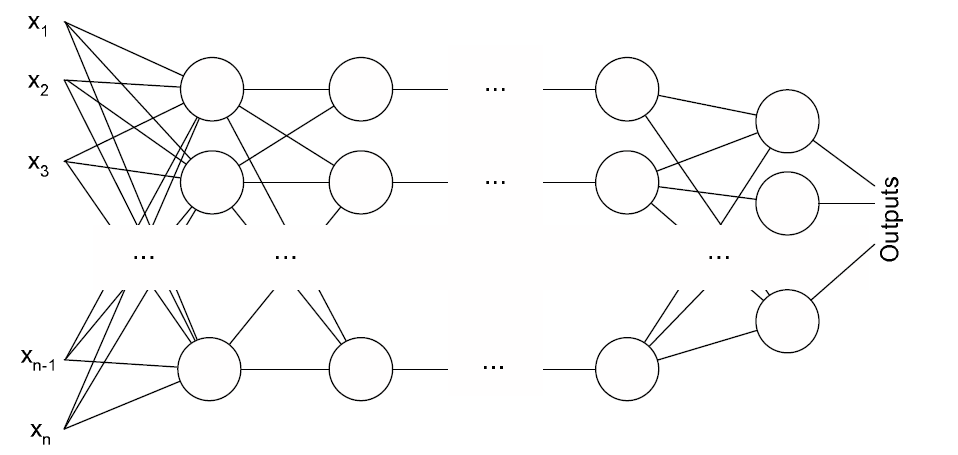


Размерность входных и выходных данных может быть произвольной и зависит от задачи. Числа из **входного слоя** $x_{i}$ умножаются на веса w (разные для разных рёбер) и их сумма подаётся на вход нейрону из 1 скрытого слоя, в котором к этой сумме применяется так называемая **функция активация**. Далее это продолжается - нейроны 2 скрытого слоя соединены рёбрами с нейронами 1 скрытого слоя с некоторыми весами, снова проводим вышеописанную операцию, и так пока не дойдём до **выходного слоя**.

Формально, результат от одного слоя к другому преобразуется по формуле
$$y_{j} = f(\sum_{i} w_{ij} x_{i}) $$
Здесь $x_{i}$ - значение, соответствующее i-му нейрону на первом слое, $y_{j}$ - j-му нейрону на втором слое, f - функция активации (вообще говоря, может быть разной для разных нейронов), $w_{ij}$ - вес, соответствующий ребру, соединяющему i-й нейрон первого слоя и j-й нейрон второго слоя.

Само обучение нейронной сети происходит с помощью обратного распространения ошибки или **backpropagation**. Если у нас есть тренировочная выборка, то мы можем (произвольно выбрав веса), получить некоторый результат, вычислить погрешность (например, по MSE), а далее подправлять веса после каждого обучающего примера - с помощью стохастического градиентного спуска пытаться найти оптимальные веса, дающие минимум ошибки.

Аккуратно расписав, можно получить формулу вычисляющую градиент весов более раннего слоя через градиенты более позднего слоя, таким образом и получаем обратное распространение ошибки - вычислив ошибку в слое перед выходом, двигаясь по слоям к входу обновляем все веса.

### Применение перцептрона для решения дифференциальных уравнений

Теперь опишем метод, который можно применить для решения задачи Коши и краевой задачи для ОДУ и УРЧП. Для более глубокого понимания можно ознакомиться с оригинальной статьей 1997 года [Artificial Neural Networks for Solving Ordinary and Partial Differential Equations](https://arxiv.org/abs/physics/9705023).

Зададим дифференциальное уравнение в самой общей форме

$$
\begin{equation*}
D\left(x, f(x), \nabla f(x), \nabla^{2} f(x), \ldots, \nabla^{m} f(x)\right)=0, \quad x \subset \mathbb{R}^{n}
\end{equation*}
$$
Необходимо также задать граничные условия, пока не уточняем, в каком виде (будем делать это для конкретных примеров).

Возьмём пробное решение в виде
$$
\begin{equation*}
\hat{f}(x ; \theta)=B(x)+F(x, N(x ; \theta))
\end{equation*}
$$
Здесь $N(x ; \theta)$ - выход нейронной сети, $B(x)$ - функция, удовлетворяющая граничным условиям и не имеющая настраиваемых параметров (она остаётся неизменной по ходу обучения нейронной сети), $F(x, N(x ; \theta))$ -  функция, удовлетворяющая нулевым граничным условиям - таким образом $\hat{f}$ удовлетворяет граничным условиям.

Возьмём обучающую выборку размера $M$ - точки $x_{1}, x_{2}, \ldots, x_{M}$ из интервала, на котором нас интересует решение дифференциального уравнения, и зададим функцию потерь следующим образом:

$$
\begin{equation*}
J(\theta)=\frac{1}{M} \sum_{j=1}^{M} D\left(x_{j}, \hat{f}\left(x_{j} ; \theta\right), \nabla \hat{f}\left(x_{j} ; \theta\right), \nabla^{2} \hat{f}\left(x_{j} ; \theta\right), \ldots, \nabla^{m} \hat{f}\left(x_{j} ; \theta\right)\right)^{2}
\end{equation*}
$$
Нетрудно догадаться, что задать ошибку как обычно в виде $ \frac{1}{M} \sum_{j=1}^{M} (f(x_{j})-\hat{f}(x_{j}))^{2}$ невозможно, ведь мы не знаем сами значения функции $f$, нам известно только то, что $f$ удовлетворяет заданному дифференциальному уравнению. Минимизируя функцию потерь $J(\theta) \rightarrow 0$ мы надеемся получить решение, максимально близкое к истинному.

Следует отметить, что из выражения для функции потерь видно, что линейная функция активации и ReLU не подходят, так как их вторые производные обращаются в ноль, поэтому следует использовать сигмоиду или гиперболический тангенс. Однако, чтобы не ограничивать диапазон выходных данных (область значений сигмоиды и $tanh$ ограничены), на последнем слое используем обычную линейную функцию.




## ОДУ первого порядка

### Общая информация

В данном разделе мы на примере покажем, как применяется описанный метод в самом простом случае. Пусть стоит задача решения на отрезке $[a, b]$ уравнения
$$
\begin{equation*}
\frac{d f(x)}{d x}=G(x, f(x))
\end{equation*}
$$
с условием $f(a) = A \in \mathbb{R} $.

Полагая (в вышеуказанных обозначениях) $B \equiv A$, $F(x, N(x ; \theta)) = (x-a) N(x ; \theta) $, получаем $\hat{f} = A + (x-a) N(x ; \theta) $, то есть, что и требовалось, $\hat{f}$ удовлетворяет граничному условию независимо от выхода нейросети.

Функция потерь для такого дифференциального уравнения будет задаваться выражением
$$
\begin{equation*}
J(\theta)=\frac{1}{M} \sum_{j=1}^{M}\left(\frac{\partial \hat{f}\left(x_{j} ; \theta\right)}{\partial x}-G\left(x_{j}, \hat{f}\left(x_{j} ; \theta\right)\right)\right)^{2}
\end{equation*}
$$

Также необходимо посчитать производную от пробной функции
$$
\begin{equation*}
\frac{\partial \hat{f}(x ; \theta)}{\partial x}=N(x ; \theta)+(x-a) \frac{\partial N(x ; \theta)}{\partial x}
\end{equation*}
$$

### Пример 1

Рассмотрим теперь конкретное уравнение (взятое из той же оригинальной статьи, указанной выше):
$$
\begin{equation*}
\frac{d f(x)}{d x}=x^{3}+2 x+x^{2} \frac{1+3 x^{2}}{1+x+x^{3}}-\left(x+\frac{1+3 x^{2}}{1+x+x^{3}}\right) f(x)
\end{equation*}
$$
с граничным условием $f(0) = 1$

Аналитическое решение (для сравнения результаты работы нейронной сети и истинного результата):
$$
\begin{equation*}
f(x)=\frac{e^{-\frac{x^{2}}{2}}}{1+x+x^{3}}+x^{2}
\end{equation*}
$$

Теперь мы готовы обучить простейшую нейронную сеть, используя Torch.

Наша нейронная сеть будет состоять из двух скрытых слоёв с регулируемым количеством нейронов. В качестве функции активации используем $tanh$.
Сначала попробуем обучить на 10000 эпохах с использованием Adam.

MSE между аналитическим и полученным решениями =  4.019771626673219e-09


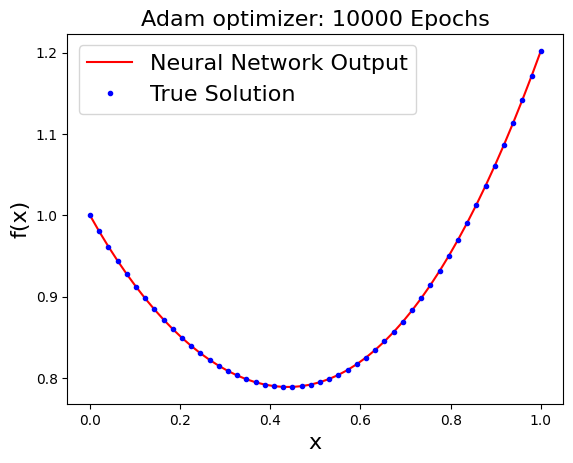

10000 final loss =  6.5465434e-07
time =  42.66474175453186  s


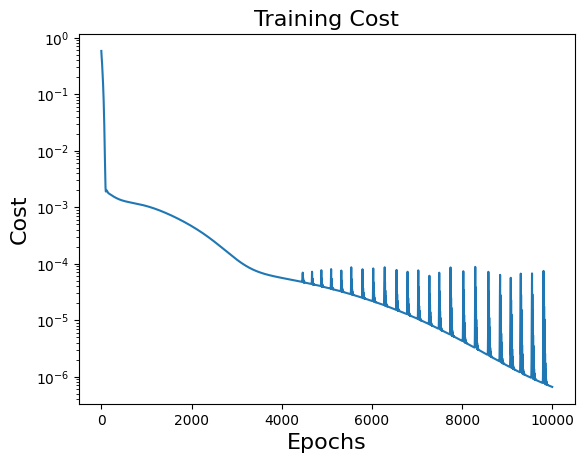

In [ ]:
import torch
import torch.utils.data
import numpy as np
import matplotlib.pyplot as plt
import time
from torch.autograd import grad

class DataSet(torch.utils.data.Dataset):
    """
    Класс для создания объектов, делающих torch-массивы в указанном промежутке
    с указанным количеством точек
    """
    def __init__(self, numSamples, xRange):

        self.dataIn  = torch.linspace(xRange[0], xRange[1], numSamples, requires_grad=True).view(-1,1)

    def __len__(self):

        return len(self.dataIn)

    def __getitem__(self, idx):

        return self.dataIn[idx]


class Fitter(torch.nn.Module):
    """
    Собственно нейронная сеть, состоящая из одного входного и двух скрытых слоёв
    с одинаковым количеством нейронов
    """
    def __init__(self, numHiddenNodes):

        super(Fitter, self).__init__()
        self.fc1 = torch.nn.Linear(in_features = 1, out_features = numHiddenNodes)
        self.fc2 = torch.nn.Linear(in_features = numHiddenNodes, out_features = numHiddenNodes)
        self.fc3 = torch.nn.Linear(in_features = numHiddenNodes, out_features = 1)

    def forward(self, x):
        """
        Прямой ход нейронной сети
        """
        h = torch.tanh(self.fc1(x))
        h1 = torch.tanh(self.fc2(h))
        y = self.fc3(h1)
        return y

def plotNetwork(network, descentType, epoch):
    '''
    Функция для построения графиков и вывода результатов
    '''
    x    = torch.linspace(xRange[0], xRange[1], 50, requires_grad=True).view(-1,1)
    N    = network.forward(x)
    f_trial = trialFunc(x, N)
    exact = solution(x)
    MSECost = lossFn(f_trial, exact)
    print("MSE между аналитическим и полученным решениями = ", MSECost.item())
    exact = exact.detach().numpy()
    x = x.detach().numpy()
    N = N.detach().numpy()
    plt.plot(x, trialFunc(x,N), 'r-', label = "Neural Network Output")
    plt.plot(x, exact, 'b.', label = "True Solution")

    plt.xlabel("x", fontsize = 16)
    plt.ylabel("f(x)", fontsize = 16)
    plt.legend(loc = "upper left", fontsize = 16)
    plt.title(descentType + str(epoch) + " Epochs", fontsize = 16)
    plt.show()

def trialFunc1(x, n_out):
    """
    Тестовая функция. В вышенаписанных обозначениях B = 1, F(x, N) = x*N
    """
    return 1 + x * n_out

def dTrialFunc1(x, n_out, dndx):
    """
    Промзводная от тестовой функции
    """
    return n_out + x * dndx

def diffEq1(x, f_trial, df_trial):
    """
    По сути возвращает невязку при подстановке пробной функции"""
    RHS = x**3 + 2*x + (x**2 * ((1+3*x**2) / (1 + x + x**3)))
    LHS = df_trial + ((x + (1+3*(x**2)) / (1 + x + x**3) ) * f_trial)
    return LHS - RHS

def solution1(x):
    """
    Аналитическое решение задачи - для сравнения """
    y =  (torch.exp(-(x**2)/2) / (1 + x + x**3)) + x**2
    return y

descentType = "Adam optimizer: "

def train(network, loader, lossFn, optimiser, numEpochs):
    """
    Данная функция непосредственно обучает нейронную сеть. loader генерирует
    батчи, lossFn - функция потерь
    """
    cost_list=[]
    network.train(True)
    for epoch in range(numEpochs):
        for batch in loader:
            n_out = network.forward(batch)
            dndx = grad(n_out, batch, torch.ones_like(n_out), retain_graph=True)[0]
            f_trial = trialFunc(batch, n_out)
            df_trial = dTrialFunc(batch, n_out, dndx)
            diff_eq = diffEq(batch, f_trial, df_trial)
            cost = lossFn(diff_eq, torch.zeros_like(diff_eq))
            cost.backward()
            optimiser.step()
            optimiser.zero_grad()

        cost_list.append(cost.detach().numpy())
    network.train(False)
    return cost_list

network    = Fitter(numHiddenNodes=15)

xRange       = [0, 1]
numSamples   = 30
batchSize    = 30
paramUpdates = 20000
train_set    = DataSet(numSamples, xRange)
train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=batchSize, shuffle=True)
lossFn       = torch.nn.MSELoss()
optimiser    = torch.optim.Adam(network.parameters(), lr=1e-3)

solution = solution1
trialFunc = trialFunc1
dTrialFunc = dTrialFunc1
diffEq = diffEq1

costList = []

totalEpochs = 10000
epoch = totalEpochs
start = time.time()
costList.extend(train(network, train_loader, lossFn, optimiser, totalEpochs))
end = time.time()


plotNetwork(network, descentType, epoch)
print(epoch, "final loss = ", costList[-1])
print("time = ", end - start, " s")

plt.semilogy(costList)
plt.xlabel("Epochs",fontsize = 16)
plt.ylabel("Cost",fontsize = 16)
plt.title("Training Cost",fontsize = 16)
plt.show()


Попробуем для той же задачи другие встроенные инструменты: SGD и Rprop

MSE между аналитическим и полученным решениями =  7.396176079055294e-05


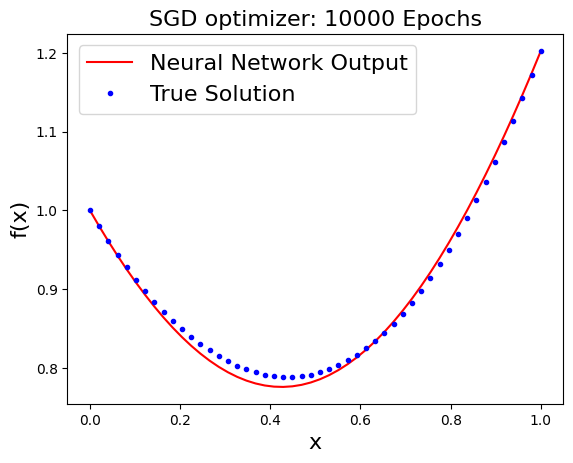

10000 final loss =  0.0031332911
time =  38.053231954574585  s


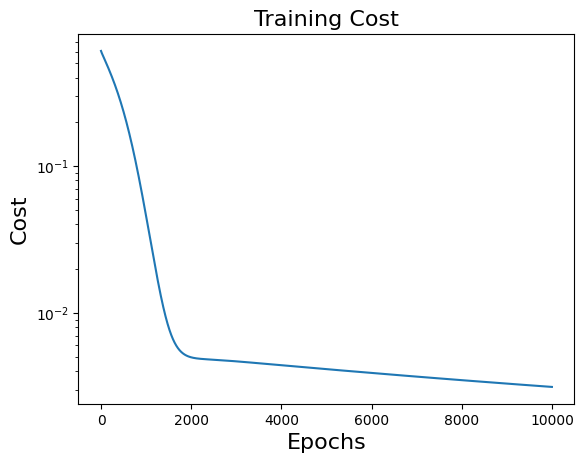

In [ ]:
descentType = "SGD optimizer: "

network    = Fitter(numHiddenNodes=15)

xRange       = [0, 1]
numSamples   = 30
batchSize    = 30
paramUpdates = 20000
train_set    = DataSet(numSamples, xRange)
train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=batchSize, shuffle=True)
lossFn       = torch.nn.MSELoss()
optimiser    = torch.optim.SGD(network.parameters(), lr=1e-3)

solution = solution1
trialFunc = trialFunc1
dTrialFunc = dTrialFunc1
diffEq = diffEq1

costList = []

totalEpochs = 10000
epoch = totalEpochs
start = time.time()
costList.extend(train(network, train_loader, lossFn, optimiser, totalEpochs))
end = time.time()


plotNetwork(network, descentType, epoch)
print(epoch, "final loss = ", costList[-1])
print("time = ", end - start, " s")

plt.semilogy(costList)
plt.xlabel("Epochs",fontsize = 16)
plt.ylabel("Cost",fontsize = 16)
plt.title("Training Cost",fontsize = 16)
plt.show()



MSE между аналитическим и полученным решениями =  3.45977468896308e-08


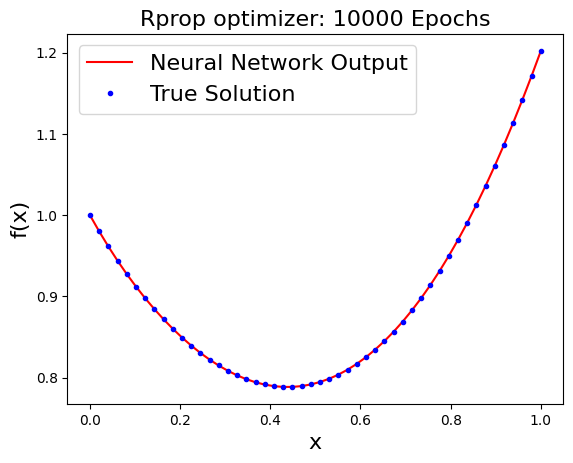

10000 final loss =  9.24325e-06
time =  44.722307205200195  s


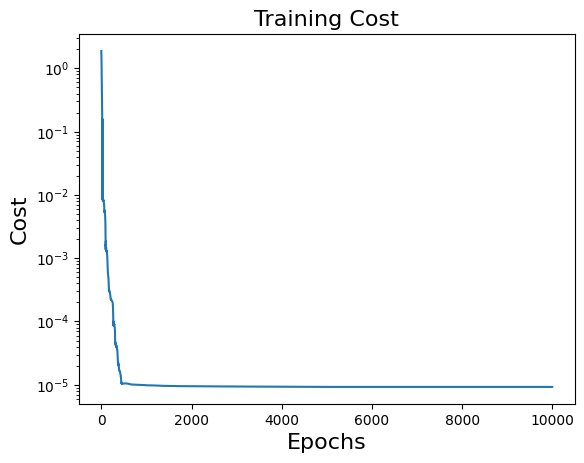

In [ ]:
descentType = "Rprop optimizer: "

network    = Fitter(numHiddenNodes=15)

xRange       = [0, 1]
numSamples   = 30
batchSize    = 30
paramUpdates = 20000
train_set    = DataSet(numSamples, xRange)
train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=batchSize, shuffle=True)
lossFn       = torch.nn.MSELoss()
optimiser    = torch.optim.Rprop(network.parameters(), lr=1e-3)

solution = solution1
trialFunc = trialFunc1
dTrialFunc = dTrialFunc1
diffEq = diffEq1

costList = []

totalEpochs = 10000
epoch = totalEpochs
start = time.time()
costList.extend(train(network, train_loader, lossFn, optimiser, totalEpochs))
end = time.time()


plotNetwork(network, descentType, epoch)
print(epoch, "final loss = ", costList[-1])
print("time = ", end - start, " s")

plt.semilogy(costList)
plt.xlabel("Epochs",fontsize = 16)
plt.ylabel("Cost",fontsize = 16)
plt.title("Training Cost",fontsize = 16)
plt.show()



Эксперименты с размерами батчей и разными оптимайзерами показывают, что Adam является эффективным и универсальным решением, а в качестве размера батча лучше брать всю выборку (пока количество точек не слишком большое), выбирая достаточно большое количество эпох (не менее нескольких тысяч).

### Пример 2

Возьмём теперь другое уравнение первого порядка на отрезке $[0, 10]$
$$
\begin{equation*}
\frac{d f(x)}{d x}=e^{-\frac{x}{5}} \cos (x)-\frac{1}{5} f(x)
\end{equation*}
$$
с условием $f(0) = 0$.

Аналитическое решение $$
\begin{equation*}
f(x)=e^{-\frac{x}{5}} \sin (x)
\end{equation*}
$$

Для его решения применим ровно тот же способ, что и ранее


MSE между аналитическим и полученным решениями =  3.0525476176990196e-05


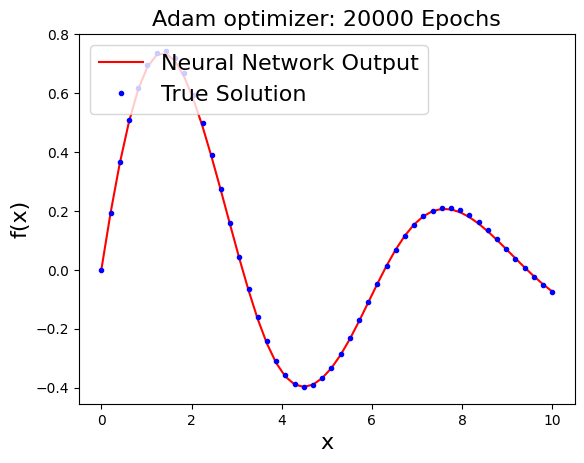

20000 final loss =  6.130902e-05
time =  94.68450498580933  s


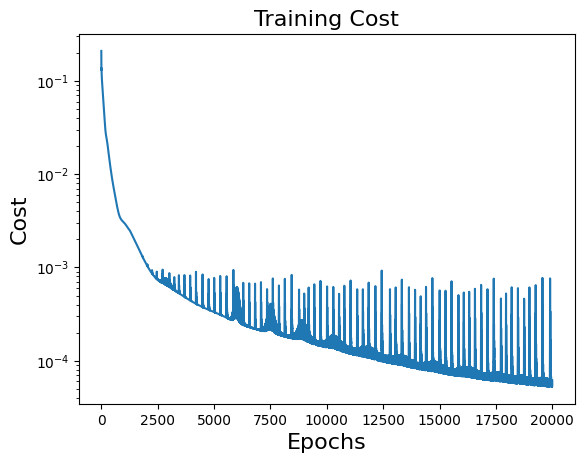

In [ ]:
def trialFunc1(x, n_out):
    """
    Тестовая функция. В вышенаписанных обозначениях B = 0, F(x, N) = x*N
    """
    return x * n_out

def dTrialFunc1(x, n_out, dndx):
    """
    Промзводная от тестовой функции
    """
    return n_out + x * dndx

def diffEq1(x, f_trial, df_trial):
    """
    По сути возвращает невязку при подстановке пробной функции"""
    RHS = df_trial + (1/5)*f_trial
    LHS = torch.exp(-x/5) * torch.cos(x)
    return LHS - RHS

def solution1(x):
    """
    Аналитическое решение задачи - для сравнения """
    y = torch.exp(-x/5) * torch.sin(x)
    return y


descentType = "Adam optimizer: "

def train(network, loader, lossFn, optimiser, numEpochs):
    """
    Данная функция непосредственно обучает нейронную сеть. loader генерирует
    батчи, lossFn - функция потерь
    """
    cost_list=[]
    network.train(True)
    for epoch in range(numEpochs):
        for batch in loader:
            n_out = network.forward(batch)
            dndx = grad(n_out, batch, torch.ones_like(n_out), retain_graph=True)[0]
            f_trial = trialFunc(batch, n_out)
            df_trial = dTrialFunc(batch, n_out, dndx)
            diff_eq = diffEq(batch, f_trial, df_trial)
            cost = lossFn(diff_eq, torch.zeros_like(diff_eq))
            cost.backward()
            optimiser.step()
            optimiser.zero_grad()

        cost_list.append(cost.detach().numpy())
    network.train(False)
    return cost_list

network    = Fitter(numHiddenNodes=15)

xRange       = [0, 10]
numSamples   = 50
batchSize    = 50
paramUpdates = 20000
train_set    = DataSet(numSamples, xRange)
train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=batchSize, shuffle=True)
lossFn       = torch.nn.MSELoss()
optimiser    = torch.optim.Adam(network.parameters(), lr=1e-3)

solution = solution1
trialFunc = trialFunc1
dTrialFunc = dTrialFunc1
diffEq = diffEq1

costList = []

totalEpochs = 20000
epoch = totalEpochs
start = time.time()
costList.extend(train(network, train_loader, lossFn, optimiser, totalEpochs))
end = time.time()


plotNetwork(network, descentType, epoch)
print(epoch, "final loss = ", costList[-1])
print("time = ", end - start, " s")

plt.semilogy(costList)
plt.xlabel("Epochs",fontsize = 16)
plt.ylabel("Cost",fontsize = 16)
plt.title("Training Cost",fontsize = 16)
plt.show()


## ОДУ второго порядка

### Общая информация

Покажем, что ничего страшного в ОДУ второго и более высоких порядков нет - алгоритм всё тот же:


**1. Составить выражение для пробной функции, удовлетворяющее заданным условиям вне зависимости от выхода нейронной сети**

**2. Нужное количество раз взять производную от этого выражения**

**3. Засунуть всё это в нейронную сеть, предварительно задав её конфигурацию, и долго ждать, пока всё досчитается**

Рассмотрим на примере ОДУ второго порядка на отрезке $[a, b]$
$$
\begin{equation*}
\frac{d^{2} f(x)}{d x^{2}}=G\left(x, f(x), \frac{d f(x)}{d x}\right)
\end{equation*}
$$
Для ОДУ второго порядка уже есть свобода в выборе вида граничных условий.

#### **1) Задача Коши**
$f(a)=A \in \mathbb{R}, f^{\prime}(a)=A^{\prime} \in \mathbb{R}$

Составим пробную функцию в виде
\begin{equation*}
\hat{f}(x ; \theta)=A+A^{\prime}(x-a)+(x-a)^{2} N(x ; \theta)
\end{equation*}
Эта функция удовлетворяет условиям независимо от $N(x ; \theta)$

Можно вычислить производные
$$
\begin{align*}
\frac{\partial \hat{f}(x ; \theta)}{\partial x} & =A^{\prime}+(x-a)\left[2 N(x ; \theta)+(x-a) \frac{\partial N(x ; \theta)}{\partial x}\right] \\
\frac{\partial^{2} \hat{f}(x ; \theta)}{d x^{2}} & =2 N(x ; \theta)+4(x-a) \frac{\partial N(x ; \theta)}{d x}+(x-a)^{2} \frac{\partial^{2} N(x ; \theta)}{d x^{2}}
\end{align*}
$$
$$
\begin{equation*}
J(\theta)=\frac{1}{M} \sum_{j=1}^{M}\left(\frac{\partial^{2} \hat{f}\left(x_{j} ; \theta\right)}{\partial x^{2}}-G\left(x_{j}, \hat{f}\left(x_{j} ; \theta\right), \frac{\partial \hat{f}\left(x_{j} ; \theta\right)}{\partial x}\right)\right)^{2}
\end{equation*}
$$

#### **2) Краевая задача (условия Дирихле)**
$f(a)=A \in \mathbb{R}, f(b)=B \in \mathbb{R}$

$$
\begin{equation*}
\hat{f}(x ; \theta)=A \frac{(b-x)}{b-a}+B \frac{(x-a)}{b-a}+(x-a)(b-x) N(x ; \theta)
\end{equation*}
$$

Остальные увлекательные шаги для условий Дирихле в виде вычисления производных читатель может проделать самостоятельно.

### Пример (задача Коши)

Приведём уравнение, точное решение которого будет совпадать с решением примера 2 из пункта про ОДУ первого порядка.

\begin{equation*}
\frac{d^{2} f(x)}{d x^{2}}=-\frac{1}{5} \frac{d f(x)}{d x}-f(x)-\frac{1}{5} e^{-\frac{x}{5}} \cos (x)
\end{equation*}

\begin{equation*}
f(0)=0, f^{\prime}(0)=1
\end{equation*}


Аналитическое решение
\begin{equation*}
f(x)=e^{-\frac{x}{5}} \sin (x)
\end{equation*}


С учётом граничных условий пробная функция запишется как
\begin{equation*}
\hat{f}(x ; \theta)=x+x^{2} N(x ; \theta)
\end{equation*}

time =  95.71402382850647  s
20000 epochs total, final cost =  0.00063963764
MSE между аналитическим и полученным решениями =  1.6742815205361694e-05


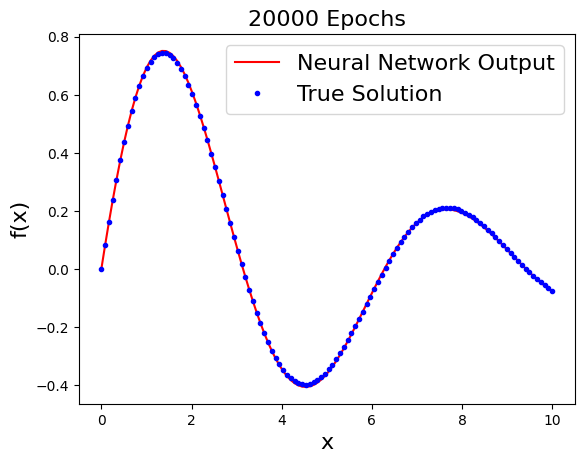

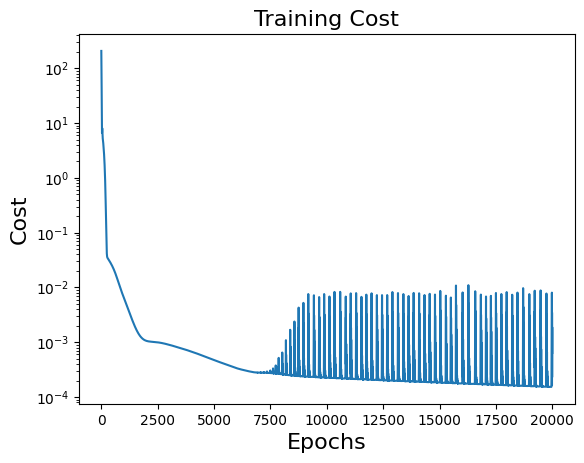

In [ ]:

import torch
import torch.utils.data
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import grad
import time

class DataSet(torch.utils.data.Dataset):
    def __init__(self, numSamples, xRange):
        self.dataIn  = torch.linspace(xRange[0], xRange[1], numSamples, requires_grad=True).view(-1,1)
    def __len__(self):
        return len(self.dataIn)

    def __getitem__(self, idx):
        return self.dataIn[idx]

class Fitter(torch.nn.Module):
    def __init__(self, numHiddenNodes):
        super(Fitter, self).__init__()
        self.fc1 = torch.nn.Linear(in_features = 1, out_features = numHiddenNodes)
        self.fc2 = torch.nn.Linear(in_features = numHiddenNodes, out_features = 1)

    def forward(self, x):
        h = torch.tanh(self.fc1(x))
        y = self.fc2(h)
        return y

def train(network, loader, lossFn, optimiser, numEpochs):
    cost_list=[]
    network.train(True)
    for epoch in range(numEpochs):
        for batch in loader:
            n_out = network(batch)
            dndx = grad(n_out, batch, torch.ones_like(n_out), retain_graph=True, create_graph=True)[0]
            d2ndx2 =grad(dndx, batch, torch.ones_like(dndx), retain_graph=True)[0]
            f_trial = trialFunc(batch, n_out)
            df_trial = dTrialFunc(batch, n_out, dndx)
            d2f_trial = d2TrialFunc(batch,n_out,dndx,d2ndx2)
            diff_eq = diffEq(batch, f_trial, df_trial, d2f_trial)
            cost = lossFn(diff_eq, torch.zeros_like(diff_eq))
            cost.backward()
            optimiser.step()
            optimiser.zero_grad()

        cost_list.append(cost.detach().numpy())
    network.train(False)
    return cost_list


def plotNetwork(network, epoch):
    x    = torch.linspace(0, 10, 120, requires_grad=True).view(-1,1)
    N    = network.forward(x)
    f_trial = trialFunc(x, N)
    dndx = grad(N, x, torch.ones_like(N), retain_graph=True, create_graph=True)[0]
    d2ndx2 =grad(dndx, x, torch.ones_like(dndx), retain_graph=True)[0]
    df_trial = dTrialFunc(x, N, dndx)
    d2f_trial = d2TrialFunc(x,N,dndx,d2ndx2)
    diff_eq = diffEq(x, f_trial, df_trial, d2f_trial)
    cost = lossFn(diff_eq, torch.zeros_like(diff_eq))

    exact = solution(x)
    MSECost = lossFn(f_trial, exact)
    print("MSE между аналитическим и полученным решениями = ", MSECost.item())
    exact = exact.detach().numpy()
    x = x.detach().numpy()
    N = N.detach().numpy()
    plt.plot(x, trialFunc(x,N), 'r-', label = "Neural Network Output")
    plt.plot(x, exact, 'b.', label = "True Solution")
    plt.xlabel("x", fontsize = 16)
    plt.ylabel("f(x)", fontsize = 16)
    plt.legend(loc = "upper right", fontsize = 16)
    plt.title(str(epoch) + " Epochs", fontsize = 16)
    plt.show()
    return


def trialFunc(x, n_out):
    return x + (x**2 * n_out)

def dTrialFunc(x, n_out, dndx):
    return 1 + (2*x*n_out) + (x**2 * dndx)

def d2TrialFunc(x,n_out,dndx,d2ndx2):
    return 2*n_out + (4*x*dndx) + (x**2 * d2ndx2)

def diffEq(x, f_trial, df_trial, d2f_trial):
    LHS = d2f_trial + (1/5)*df_trial + f_trial
    RHS = -(1/5) * torch.exp(-x/5) * torch.cos(x)
    return LHS - RHS

def solution(x):
    return torch.exp(-x/5) * torch.sin(x)

network = Fitter(numHiddenNodes=10)
costList = []

xRangeWide       = [0, 10]
numSamplesWide   = 50
batchSizeWide    = 50
trainDataWide    = DataSet(numSamplesWide, xRangeWide)
trainLoaderWide  = torch.utils.data.DataLoader(dataset=trainDataWide, batch_size=batchSizeWide, shuffle=True)

lossFn      = torch.nn.MSELoss()
optimiser   = torch.optim.Adam(network.parameters(), lr=1e-3)
epoch       = 0
numEpochs   = 1000
totalEpochs = 20000

start = time.time()
while epoch < totalEpochs:
    costList.extend(train(network, trainLoaderWide, lossFn, optimiser, numEpochs))
    epoch += numEpochs
end = time.time()


print("time = ", end-start, " s")
print(epoch, "epochs total, final cost = ", costList[-1])

plotNetwork(network, epoch)
plt.semilogy(costList)
plt.xlabel("Epochs",fontsize = 16)
plt.ylabel("Cost",fontsize = 16)
plt.title("Training Cost",fontsize = 16)
plt.show()

## УРЧП

### Общая информация

Нетрудно обобщить описанный выше метод для решения УРЧП. Рассмотрим двумерное уравнение Пуассона (как один из самых простых примеров УРЧП):

$$
\begin{equation*}
\frac{\partial^{2}}{\partial x^{2}} f(x, y)+\frac{\partial^{2}}{\partial y^{2}} f(x, y)=G(x, y)
\end{equation*}
$$
где $x \in[a, b], y \in[c, d]$

Можно задавать разные граничные условия, в том числе Неймана или смешанные, однако для простоты ограничимся условиями Дирихле - для других случаев всё идейно аналогично, но формулы более громоздкие.

Таким образом $f(a, y)=$ $A(y), f(b, y)=B(y), f(x, c)=C(x)$ и $f(x, d)=D(x)$.


\begin{equation*}
\hat{f}(x, y ; \theta)=E(x, y)+(x-a)(b-x)(y-c)(d-y) N(x, y ; \theta)
\end{equation*}



Функция перед $N(x, y ; \theta)$ подбирается легко, ведь она должна просто занулиться на границах прямоугольника. А вот с $E(x, y)$ всё сложнее - придумать функцию, принимающую заданные значения на границе быстро не получается.

К счастью, всё уже придумали за нас, можно просто подставить граничные значения и убедиться, что всё работает:

$$
\begin{align*}
E(x, y)= & \frac{b-x}{b-a} A(y)+\frac{x-a}{b-a} B(y)+\frac{d-y}{d-c}\left\{C(x)-\left[\frac{b-x}{b-a} C(a)+\frac{x-a}{b-a} C(b)\right]\right\} +\frac{y-c}{d-c}\left\{D(x)-\left[\frac{b-x}{b-a} D(a)+\frac{x-a}{b-a} D(b)\right]\right\}
\end{align*}
$$
Стандартным образом также пишется квадрат невязки:
$$
\begin{equation*}
J(\theta)=\sum_{j=1}^{M}\left(\frac{\partial^{2}}{\partial x^{2}} \hat{f}\left(x_{j}, y_{j} ; \theta\right)+\frac{\partial^{2}}{\partial y^{2}} f\left(x_{j}, y_{j} ; \theta\right)-G\left(x_{j}, y_{j}\right)\right)^{2}
\end{equation*}
$$

### Пример

Рассмотрим следующее уравнение на квадрате $\in[0,1] \times[0,1]$
\begin{equation*}
\frac{\partial^{2}}{\partial x^{2}} f(x, y)+\frac{\partial^{2}}{\partial y^{2}} f(x, y)=e^{-x}\left(x-2+y^{3}+6 y\right)
\end{equation*}
с граничными условиями
$f(0, y)=y^{3}, f(1, y)=\left(1+y^{3}\right) e^{-1}$, $f(x, 0)=x e^{-x}$ и $f(x, 1)=e^{-x}(x+1)$

Как описано в общей информации к этому разделу, выбираем
\begin{equation*}
\hat{f}(x, y ; \theta)=E(x, y)+x(1-x) y(1-y) N(x, y ; \theta)
\end{equation*}

$$
\begin{align*}
E(x, y)= & (1-x) y^{3}+x\left(1+y^{3}\right) e^{-1}+(1-y) x\left(e^{-x}-e^{-1}\right) \\
& +y\left[e^{-x}(x+1)-\left(1-x+2 e^{-1} x\right)\right]
\end{align*}
$$
Аналитическое решение при этом выглядит очень просто:
$$f(x, y)=e^{-x}\left(x+y^{3}\right)$$

/usr/local/lib/python3.10/dist-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


30000 epochs total, final cost = 1.3263698406262847e-07


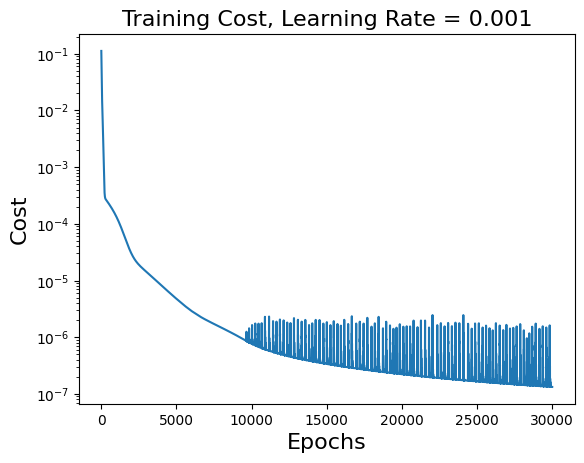

test cost =  1.2643322122585232e-07
MSE полученным и аналитическим решением =  1.1546887e-06


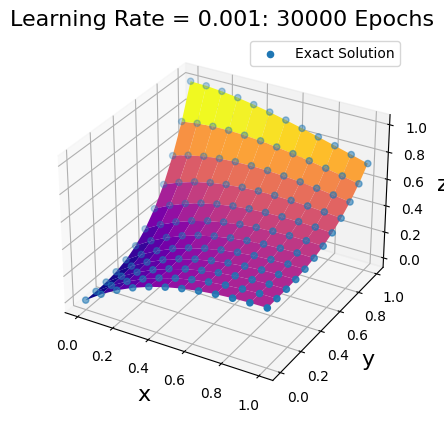

In [ ]:
import torch
import torch.utils.data
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import grad


class DataSet(torch.utils.data.Dataset):

    def __init__(self, xRange, yRange, numSamples):
        X  = torch.linspace(xRange[0],xRange[1],numSamples, requires_grad=True)
        Y  = torch.linspace(yRange[0],yRange[1],numSamples, requires_grad=True)
        grid = torch.meshgrid(X,Y)
        self.data_in = torch.cat((grid[0].reshape(-1,1),grid[1].reshape(-1,1)),1)

    def __len__(self):
        return self.data_in.shape[0]

    def __getitem__(self, i):
        return self.data_in[i]

class PDESolver(torch.nn.Module):
    def __init__(self, numHiddenNodes):
        super(PDESolver, self).__init__()
        self.fc1 = torch.nn.Linear(in_features = 2, out_features = numHiddenNodes)
        self.fc2 = torch.nn.Linear(in_features = numHiddenNodes, out_features = 1)

    def forward(self, input):
        h = torch.tanh(self.fc1(input))
        z = self.fc2(h)
        return z

def solution(x,y):
    return torch.exp(-x) * (x + y**3)

def trial_term(x,y):
    e_inv = np.exp(-1)
    return ((1-x)*(y**3) + x*(1+(y**3))*e_inv + (1-y)*x*(torch.exp(-x)-e_inv) +
            y * ((1+x)*torch.exp(-x) - (1-x+(2*x*e_inv))))

def trial(x,y,n_out):
    return trial_term(x,y) + x*(1-x)*y*(1-y)*n_out

def dx_trial(x,y,n_out,n_x):
    return (-torch.exp(-x) * (x+y-1) - y**3 + (y**2 +3) * y * np.exp(-1) + y
            + y*(1-y)* ((1-2*x) * n_out + x*(1-x)*n_x))

def dx2_trial(x,y,n_out,n_x,n_xx):
    return (torch.exp(-x) * (x+y-2)
            + y*(1-y)* ((-2*n_out) + 2*(1-2*x)*n_x) + x*(1-x)*n_xx)

def dy_trial(x,y,n_out, n_y):
    return (3*x*(y**2 +1) *np.exp(-1) - (x-1)*(3*(y**2)-1) + torch.exp(-x)
            + x*(1-x)* ((1-2*y) * n_out + y*(1-y)*n_y) )

def dy2_trial(x,y,n_out,n_y,n_yy):
    return (np.exp(-1) * 6 * y * (-np.exp(1)*x + x + np.exp(1))
            + x*(1-x)* ((-2*n_out) + 2*(1-2*y)*n_y) + y*(1-y)*n_yy)

def diffEq(x,y,trial_dx2,trial_dy2):
    RHS = torch.exp(-x) * (x - 2 + y**3 + 6*y)
    return trial_dx2 + trial_dy2 - RHS


def train(network, loader, lossFn, optimiser, numEpochs):

    cost_list=[]
    network.train(True)
    for epoch in range(numEpochs):
        for batch in loader:
            n_out = network(batch)

            dn = grad(n_out, batch, torch.ones_like(n_out), retain_graph=True, create_graph=True)[0]
            dn2 = grad(dn, batch, torch.ones_like(dn), retain_graph=True, create_graph=True)[0]

            n_x, n_y = torch.split(dn, split_size_or_sections=1, dim=1)
            n_xx, n_yy = torch.split(dn2, split_size_or_sections=1, dim=1)

            x, y = torch.split(batch, 1, dim=1)
            trial_dx2 = dx2_trial(x,y,n_out,n_x,n_xx)
            trial_dy2 = dy2_trial(x,y,n_out,n_y,n_yy)
            D = diffEq(x,y, trial_dx2, trial_dy2)
            cost = lossFn(D, torch.zeros_like(D))
            cost.backward()
            optimiser.step()
            optimiser.zero_grad()

        cost_list.append(cost.item())
    network.train(False)
    return cost_list

def plotNetwork(network, epoch):

    numTestSamples = 12
    X  = torch.linspace(xRange[0],xRange[1],numTestSamples, requires_grad=True)
    Y  = torch.linspace(yRange[0],yRange[1],numTestSamples, requires_grad=True)
    x_mesh,y_mesh = torch.meshgrid(X,Y)

    input = torch.cat((x_mesh.reshape(-1,1),y_mesh.reshape(-1,1)),1)
    N = network.forward(input)

    dn = grad(N, input, torch.ones_like(N), retain_graph=True, create_graph=True)[0]
    dn2 = grad(dn, input, torch.ones_like(dn), retain_graph=True, create_graph=True)[0]
    n_x, n_y = torch.split(dn, split_size_or_sections=1, dim=1)
    n_xx, n_yy = torch.split(dn2, split_size_or_sections=1, dim=1)

    x, y = torch.split(input, split_size_or_sections=1, dim=1)

    trial_dx2 = dx2_trial(x,y,N,n_x,n_xx)
    trial_dy2 = dy2_trial(x,y,N,n_y,n_yy)

    D = diffEq(x,y, trial_dx2, trial_dy2)

    cost = lossFn(D, torch.zeros_like(D))
    print("test cost = ", cost.item())

    output = trial(x_mesh.reshape(-1,1),y_mesh.reshape(-1,1),N)
    output = output.reshape(numTestSamples,numTestSamples).detach().numpy()
    exact = solution(x_mesh,y_mesh).detach().numpy()

    surfaceError = ((output-exact)**2).mean()
    print("MSE полученным и аналитическим решением = ", surfaceError )

    x_mesh = x_mesh.detach().numpy()
    y_mesh = y_mesh.detach().numpy()
    ax = plt.axes(projection='3d')
    ax.plot_surface(x_mesh,y_mesh,output,rstride=1, cstride=1,
                cmap='plasma', edgecolor='none')
    ax.scatter(x_mesh,y_mesh,exact, label = 'Exact Solution')
    ax.set_xlabel('x', fontsize = 16)
    ax.set_ylabel('y', fontsize = 16)
    ax.set_zlabel('z', fontsize = 16)
    ax.legend()
    ax.set_title("Learning Rate = " + str(lr) + ": " + str(epoch) + " Epochs", fontsize = 16)
    plt.show()
    return surfaceError, cost.item()


lr = 1e-3

network    = PDESolver(numHiddenNodes=16)

xRange = [0,1]
yRange = [0,1]
numSamples = 10
numEpochs = 1000
costListDict = {}

lossFn      = torch.nn.MSELoss()
trainSet    = DataSet(xRange,yRange,numSamples)
trainLoader = torch.utils.data.DataLoader(dataset=trainSet, batch_size=int(numSamples**2), shuffle=True)

optimiser  = torch.optim.Adam(network.parameters(), lr = lr)
costList = []
epoch = 0
totalEpochs = 30000
while epoch < totalEpochs:
    costList.extend(train(network, trainLoader, lossFn, optimiser, numEpochs))
    epoch += numEpochs

print(f"{epoch} epochs total, final cost = {costList[-1]}")
plt.semilogy(costList)
plt.xlabel("Epochs", fontsize = 16)
plt.ylabel("Cost", fontsize = 16)
plt.title(f"Training Cost, Learning Rate = {lr}", fontsize = 16)
plt.show()

a, b = plotNetwork(network, epoch)

Получили очень маленькую ошибку, взяв всего 10*10 = 100 точек, один скрытый слой и обучившись за 3 минуты.

## Современные подходы и применения

С момента, когда впервые придумали применять нейронные сети для решения обыкновенных дифференциальных уравнений и дифференциальных уравнений в частных производных прошло почти 30 лет, соответственно, за это время были предложены некоторые изменения в алгоритме, позволяющие решать задачи более точно или применять похожий метод для решения других задач.

**Код в этом разделе может быть очень большим, а вычисления, показывающие преимущества методов - громоздкими, поэтому оставим это учёным в области нейронных сетей и познакомимся только с теоретическими аспектами**.



### Модификация

Приведём пример из аналитической механики - задача трёх тел. Хорошо известно, что если немного изменить начальные условия в такой задаче, это может привести к хаотическому движению, для нас такое поведение будет означать экспоненциально возрастающую со временем ошибку.

Тогда моменты времени для нас перестают быть равнозначными - при малых временах необходимо сильнее штрафовать за ошибку, так как такая ошибка больше искажает получаемое нами решение.

Формально можно определить **весовые функции** $W(t) = \exp(-\lambda t)$ c некоторым $\lambda > 0$ и домножать квадрат невязки на них, таким образом можно переписать функцию ошибки для ОДУ 1 порядка (и аналогично для любого другого):
$$
\begin{equation*}
J(\theta)=\frac{1}{M} \sum_{j=1}^{M}\exp(-\lambda t_{j})\left(\frac{\partial \hat{x}\left(t_{j} ; \theta\right)}{\partial t}-G\left(t_{j}, \hat{x}\left(t_{j} ; \theta\right)\right)\right)^{2}
\end{equation*}
$$

Более того, для улучшения точности при малых временах мы можем уйти при решении уравнения слегка в отрицательную область по временам, это немного усложнит вычисления, но поможет улучшить точность.

Можем пойти дальше и закидывать в нейронную сеть не только аргумент, но и начальные условия, то есть по сути будем решать задачу одновременно для разных начальных условий.

Для такого случая нам надо модифицировать пробные функции, взяв их в виде

\begin{equation*}
\hat{\mathbf{x}}\left(t, \mathbf{x}_{\mathbf{0}} ; \theta\right)=\mathbf{x}_{\mathbf{0}}+B(t) N\left(t, \mathbf{x}_{\mathbf{0}} ; \theta\right)
\end{equation*}

Здесь необходимо выбрать $B(t_{0}) = 0 $, чтобы как всегда обеспечить выполнение начальных условий, подойдёт $B(t) = 1-e^{-(t-t_{0})}$
Такой подход называется Solution Bundles (то есть "пакеты" или "пучки" решений).

Размерность решаемых задач может быть очень большой, поэтому предлагается не хранить большое количество точек, по которым мы будем проходить, а каждый раз генерировать точки из равномерного распределения по временам и начальным условиям.

Исследования показывают, что такой метод решения дифференциальных уравнений является самым лучшим с точки зрения памяти, но по времени уступает методу Рунге-Кутты. Однако, есть один нюанс - вычисления для нейронки могут быть распараллелены, поэтому в будущем нейронки могут давать более быстрые результаты.

### Curriculum learning

Иногда не удаётся сойтись к решению диффференциального уравнения -  зачастую такое случается **в системах ОДУ**, в таких случаях может помочь техника "**curriculum learning**" (дословно - "изучение учебной программы").

Мы хотим, чтобы нейронная сеть научилась сначала решать дифференциальное уравнение на самых простых отрезках. Обосновывается это тем, что нейронная сеть получает общую информацию об ОДУ на простом участке, а далее уже пытается предсказать решение на сложном.

Достаточно тяжело определить, что значит "простой" или "сложный" участок, поэтому на практике просто берут различные "учебные программы", переставляя отрезки обучения и смотрят на сходимость.

Пример из всё той же классической статьи:

\begin{aligned}
& f_1^{\prime}(x)=\cos (x)+f_1(x)^2+f_2(x)-1-x^2-\sin ^2(x) \\
& f_2^{\prime}(x)=2 x-\left(1+x^2\right) \sin (x)+f_1(x) f_2(x)
\end{aligned}
на отрезке $[0, 3]$ с условиями $f_{1} (0) = 0$, $f_{2} (0) = 1$.

Приведём результаты запусков с разными "учебными программами"

\begin{array}{|l|l|l|l|l|}
\hline \text { Row } & \text { Curriculum } & \text { Solution }  & \text { Solution Inaccuracy } \\
\hline \hline 1 & {[0,3]} & \text { Incorrect }  & 4.97 \\
\hline 2 & {[0,1.5],[0,3]} & \text { Correct }  & 3.14 \times 10^{-4} \\
\hline 3 & {[0,1],[0,2],[0,3]} & \text { Correct }  & 2.63 \times 10^{-4} \\
\hline 4 & {[0,1.5],[1.5,3]} & \text { Correct } & 1.85 \times 10^{-3} \\
\hline 5 & {[0,1],[1,2],[2,3]} & \text { Correct }  & 1.62 \times 10^{-3} \\
\hline 6 & {[0,1.5],[1.5,3],[0,3]} & \text { Correct }  & 1.84 \times 10^{-4} \\
\hline 7 & {[0,1],[1,2],[2,3],[0,3]} & \text { Correct }  & 1.69 \times 10^{-4} \\
\hline 8 & {[1.5,3],[0,3]} & \text { Incorrect } & 5.80 \\
\hline 9 & {[2,3],[1,3],[0,3]} & \text { Incorrect }  & 6.35 \\
\hline 10 & {[2.25,3],[1.5,3],[0.75,3],[0,3]} & \text { Incorrect } & 7.75 \\
\hline 11 & {[1.5,3],[0,1.5],[0,3]} & \text { Correct }  & 4.39 \times 10^{-4} \\
\hline 12 & {[2,3],[1,2],[0,1],[0,3]} & \text { Correct }& 7.85 \times 10^{-4} \\
\hline 13 & {[1.5,3],[0,1.5]} & \text { Correct } & 1.62 \times 10^{-3} \\
\hline 14 & {[2,3],[1,2],[0,1]} & \text { Correct }  & 6.78 \times 10^{-3} \\
\hline
\end{array}

Нетрудно заметить, что нейронка плохо справляется с решением системы ОДУ при обучении на всём отрезке, однако показывает хорошие результаты при обучении "по кусочкам", более того, отрезок $[0, 1.5]$ судя по всему "проще", чем отрезок $[1.5, 3]$.

### Применение для нахождения параметров дифференциального уравнения

Поставим в некотором смысле обратную задачу. Пусть дано дифференциальное уравнение
$$
\begin{equation*}
D\left(x, u(x), \nabla u(x), \nabla^{2} u(x), \ldots, \nabla^{m} u(x) ; \lambda_{1}, \ldots, \lambda_{p}\right)=0
\end{equation*}
$$
с неизвестными параметрами $\lambda_{1}, \ldots, \lambda_{p}$.

Пусть нам известны значения решения данного дифференциального уравнения $u_{1}, \ldots, u_{M}$ в некоторых точках $x_{1}, \ldots, x_{M}$. По этим данным мы хотим восстановить значения параметров $\lambda$.

Сделать это можно следующим образом. Возьмём в качестве функции, которую мы будем минимизировать
$$
\begin{equation*}
J\left(\theta, \lambda_{1}, \ldots, \lambda_{p}\right)=J_{u}(\theta)+J_{D}\left(\theta, \lambda_{1}, \ldots, \lambda_{p}\right)
\end{equation*}
$$
$$
\begin{align*}
J_{u} & =\frac{1}{M} \sum_{j=1}^{M}\left(N\left(x_{j} ; \theta\right)-u_{j}\right)^{2} \\
J_{D} & =\frac{1}{M} \sum_{j=1}^{M} D\left(x_{j}, N\left(x_{j} ; \theta\right), \nabla N\left(x_{j} ; \theta\right), \nabla^{2} N\left(x_{j} ; \theta\right), \ldots, \nabla^{m} N\left(x_{j} ; \theta\right) ; \lambda_{1}, \ldots, \lambda_{p}\right)^{2}
\end{align*}
$$
Таким образом, необходимо оптимизировать при обучении нейронной сети не только параметры $\theta$, но и $\lambda$. При обнулении функции $J$ нейронная сеть:
1. Предсказывает решение (причём не только в точках, где функция была дана - а в любых, так как на вход нейронки можно подать любые $x$)
2. Определяет параметры дифференциального уравнения

Разумеется, если бы мы знали не только значение функции, но и все её производные в данных точках, первое слагаемое, а значит и сама нейронная сеть были бы нам не нужны - можно было бы просто спуститься градиентным спуском и найти оптимальные параметры $\lambda$.

Можно было бы обойтись без нейронки - попытаться найти производные с помощью конечно-разностных схем, однако **результат был бы заведомо хуже** - ведь нейронка определяет эти производные с учётом дифференциального уравнения, то есть будет ближе к истинному решению.